In [2]:
# %cd ..
# %cd ..

In [3]:
! ls

MemoryMaze  README.md  VizDoom	 _vizdoom.ini	   wandb
RATE_GTrXL  TMaze_new  _vizdoom  requirements.txt


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")

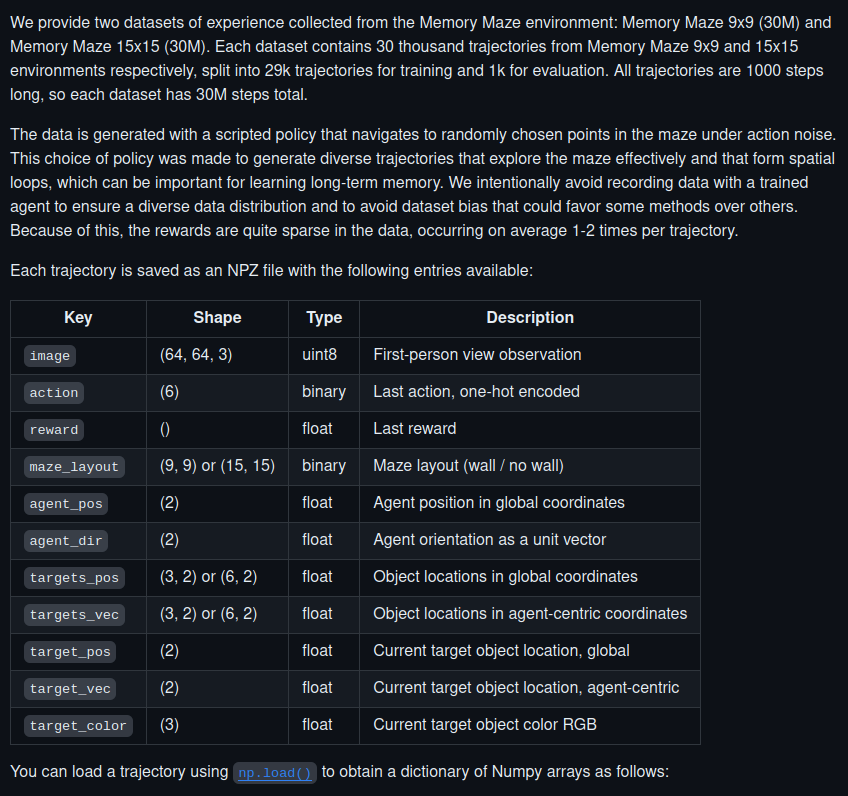

In [5]:
episode = np.load('MemoryMaze/MemoryMaze_data/9x9/20220923T110026-1000.npz')
episode = {key: episode[key] for key in episode.keys()}

assert episode['image'].shape == (1001, 64, 64, 3)
assert episode['image'].dtype == np.uint8

In [6]:
episode.keys()

dict_keys(['image', 'target_color', 'agent_pos', 'agent_dir', 'targets_vec', 'targets_pos', 'target_vec', 'target_pos', 'maze_layout', 'action', 'reward', 'terminal', 'reset'])

[0. 0. 1. 0. 0. 0.] 0.0


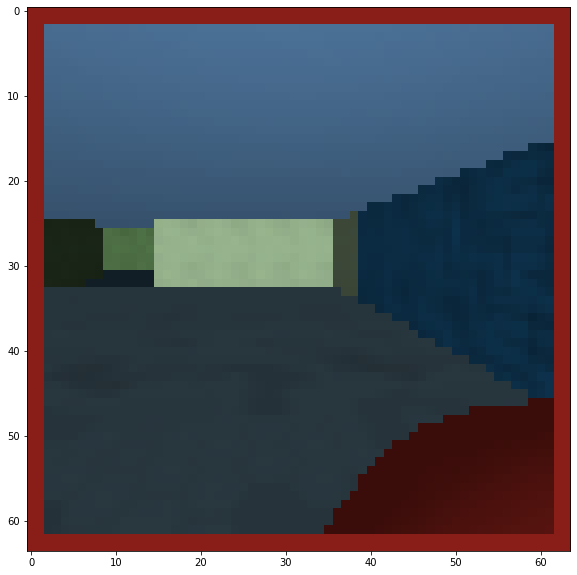

In [7]:
plt.figure(figsize=(10,10))
ind = 501
print(episode['action'][ind], episode['reward'][ind])
plt.imshow(episode['image'][ind])
plt.show()

In [15]:
from tqdm import tqdm

directory = 'MemoryMaze/MemoryMaze_data/9x9/'
file_list = os.listdir(directory)

rew_not_one = []

for file in tqdm(file_list):
    file_path = os.path.join(directory, file)
    data = np.load(file_path)
    
    rew_not_one += [int(any(data['reward'] > 0))]

  6%|▋         | 187/2900 [00:00<00:09, 280.44it/s]

100%|██████████| 2900/2900 [00:11<00:00, 258.86it/s]


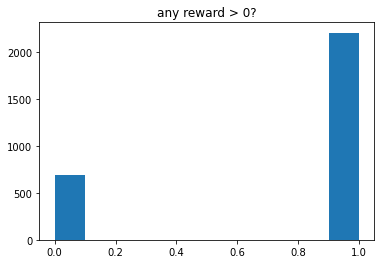

In [16]:
plt.hist(rew_not_one)
plt.title('any reward > 0?')
plt.show()

In [17]:
steps_with_rew = []

for file in tqdm(file_list):
    file_path = os.path.join(directory, file)
    data = np.load(file_path)
    
    positive_rewards = np.where(data['reward'] > 0)[0]
    steps_with_rew.extend(positive_rewards.tolist() if len(positive_rewards) > 0 else [-1])

100%|██████████| 2900/2900 [00:13<00:00, 222.19it/s]


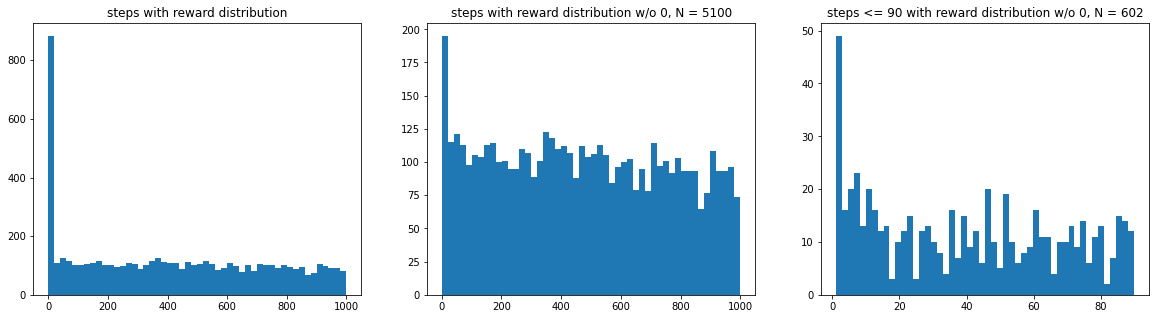

In [18]:
lst2 = []
for el in steps_with_rew:
    if el != -1:
        lst2.append(el)

lst3 = []
for el in lst2:
    if el <= 90:
        lst3.append(el)

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].hist(steps_with_rew, bins=50)
ax[0].set_title('steps with reward distribution')

ax[1].hist(lst2, bins=50)
ax[1].set_title(f'steps with reward distribution w/o 0, N = {len(lst2)}')

ax[2].hist(lst3, bins=50)
ax[2].set_title(f'steps <= 90 with reward distribution w/o 0, N = {len(lst3)}')

plt.show()

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MemoryMazeDataset(Dataset):
    def __init__(self, directory, gamma, max_length, only_non_zero_rewards):
        """_summary_

        Args:
            directory (str): path to the directory with data files
            gamma (float): discount factor
            max_length (int): maximum number of timesteps used in batch generation
                                (max in dataset: 1001)
            only_non_zero_rewards (bool): if True then use only trajectories
                                            with non-zero reward in the first
                                            max_length timesteps
        """
        self.directory = directory
        self.file_list = os.listdir(directory)
        self.gamma = gamma
        self.max_length = max_length
        self.filtered_list = []
        self.only_non_zero_rewards = only_non_zero_rewards
        if self.only_non_zero_rewards:
            self.filter_trajectories()
        print(self.filtered_list)

    def discount_cumsum(self, x):
        """
        Compute the discount cumulative sum of a 1D array.

        Args:
            x (ndarray): 1D array of values.

        Returns:
            ndarray: Discount cumulative sum of the input array.
        """
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + self.gamma * discount_cumsum[t+1]
        return discount_cumsum
    
    def filter_trajectories(self):
        for idx in range(len(self.file_list)):
            file_path = os.path.join(self.directory, self.file_list[idx])
            data = np.load(file_path)
            if any(data['reward'][:self.max_length]) > 0:
                self.filtered_list.append(self.file_list[idx])

    def __len__(self):
        if self.only_non_zero_rewards:
            return len(self.filtered_list)
        else:
            return len(self.file_list)

    def __getitem__(self, idx):
        if self.only_non_zero_rewards:
            file_path = os.path.join(self.directory, self.filtered_list[idx])
        else:
            file_path = os.path.join(self.directory, self.file_list[idx])
        data = np.load(file_path)

        image = torch.from_numpy(data['image']).permute(0, 3, 1, 2).float()
        action = torch.from_numpy(data['action'])
        # reward = torch.from_numpy(data['reward']).unsqueeze(-1)
        rtg = torch.from_numpy(self.discount_cumsum(data['reward'])).unsqueeze(-1)
        timesteps = torch.from_numpy(np.arange(0, self.max_length).reshape(-1))
        done = torch.zeros_like(timesteps)
        mask = torch.ones_like(timesteps)

        # print(image.shape, action.shape, rtg.shape, timesteps.shape, mask.shape)
        
        image = image[:self.max_length, :, :, :]
        action = action[:self.max_length, :]
        rtg = rtg[:self.max_length, :]

        return image, action, rtg, done, timesteps, mask


# Assuming 'directory_path' is the path to the directory containing .npz files
dataset = MemoryMazeDataset('MemoryMaze/MemoryMaze_data/9x9/', gamma=1.0, max_length=90, only_non_zero_rewards=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)



libgomp: Invalid value for environment variable OMP_NUM_THREADS


['20220923T100003-1000.npz', '20220923T100006-1000.npz', '20220923T100010-1000.npz', '20220923T100014-1000.npz', '20220923T100017-1000.npz', '20220923T100032-1000.npz', '20220923T100037-1000.npz', '20220923T100039-1000.npz', '20220923T100040-1000.npz', '20220923T100048-1000.npz', '20220923T100051-1000.npz', '20220923T100054-1000.npz', '20220923T100056-1000.npz', '20220923T100057-1000.npz', '20220923T100058-1000.npz', '20220923T100103-1000.npz', '20220923T100105-1000.npz', '20220923T100110-1000.npz', '20220923T100120-1000.npz', '20220923T100124-1000.npz', '20220923T100133-1000.npz', '20220923T100144-1000.npz', '20220923T100146-1000.npz', '20220923T100158-1000.npz', '20220923T100204-1000.npz', '20220923T100233-1000.npz', '20220923T100238-1000.npz', '20220923T100257-1000.npz', '20220923T100259-1000.npz', '20220923T100311-1000.npz', '20220923T100319-1000.npz', '20220923T100326-1000.npz', '20220923T100334-1000.npz', '20220923T100335-1000.npz', '20220923T100337-1000.npz', '20220923T100338-10

In [12]:
test = torch.rand(128,30,6)
print(test.shape)
argmx = torch.argmax(test, dim=-1).unsqueeze(-1)
print(argmx.shape)

torch.Size([128, 30, 6])
torch.Size([128, 30])


In [95]:
len(dataloader)

5

In [96]:
def batch_mean_and_std(loader, mode):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    print("Calculating dataset statistics...")

    if mode == 'doom':
        print(f'MODE: {mode}')
        for images, _, _, _, _, _ in tqdm(loader, total=len(loader)):
            b, l, c, h, w = images.shape
            images = images.reshape(-1, c, h, w).to(torch.float32)
            nb_pixels = b * l * h * w
            sum_ = torch.sum(images, dim=[0, 2, 3])
            sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
            cnt += nb_pixels

        mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    
    elif mode == 'memory_maze':
        print(f'MODE: {mode}')
        for images, _, _, _, _ in tqdm(loader, total=len(loader)):
            b, l, c, h, w = images.shape
            images = images.reshape(-1, c, h, w).to(torch.float32)
            nb_pixels = b * l * h * w
            sum_ = torch.sum(images, dim=[0, 2, 3])
            sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
            fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
            snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
            cnt += nb_pixels
            
        mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)       

    return mean, std

mean, std = batch_mean_and_std(dataloader, 'memory_maze')
print(mean, std)

Calculating dataset statistics...
MODE: memory_maze


100%|██████████| 5/5 [00:49<00:00,  9.86s/it]


tensor([66.0451, 74.9596, 83.1542]) tensor([41.3989, 37.3891, 46.9357])


In [97]:
def z_normalize(data, mean, std):
    """_summary_

    traj_norm.shape = torch.Size([5760, 3, 64, 112])
    """
    return (data - mean[None, :, None, None]) / std[None, :, None, None]


def inverse_z_normalize(data, mean, std):
    return data * std[None, :, None, None] + mean[None, :, None, None]

In [98]:
for batch in tqdm(dataloader, total=len(dataloader)):
    x, a, rtg, timesteps, mask = batch
    print(x.shape, a.shape, rtg.shape, timesteps.shape, mask.shape)
    break

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([128, 90, 3, 64, 64]) torch.Size([128, 90, 6]) torch.Size([128, 90, 1]) torch.Size([128, 90]) torch.Size([128, 90])


  0%|          | 0/5 [00:42<?, ?it/s]


In [99]:
 _b, _l, _c, _h, _w = x.shape
x_res = x.clone().reshape(_b*_l, _c, _h, _w)
x_res_norm = z_normalize(x_res, mean, std)
x_norm = x_res_norm.clone().reshape(_b, _l, _c, _h, _w)

In [118]:
 _b, _l, _c, _h, _w = x.shape
x_norm_res = x_norm.clone().reshape(_b*_l, _c, _h, _w)
x_inv_res = inverse_z_normalize(x_norm_res, mean, std)
x_restored = x_inv_res.clone().reshape(_b, _l, _c, _h, _w)

In [119]:
print(torch.mean(x), torch.mean(x_norm), torch.mean(x_restored))
print(torch.std(x),  torch.std(x_norm),  torch.std(x_restored))

tensor(74.5777) tensor(-0.0036) tensor(74.5777)
tensor(42.8833) tensor(1.0056) tensor(42.8833)


In [120]:
x.shape

torch.Size([128, 90, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


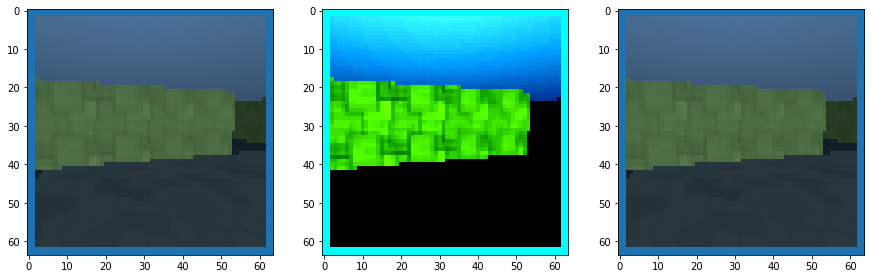

In [124]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ind = 10
t = 0

ax[0].imshow(x[ind][t].permute(1,2,0) / 255.)

ax[1].imshow(x_norm[ind][t].permute(1,2,0))

ax[2].imshow(x_restored[ind][t].permute(1,2,0) / 255.)

plt.show()

torch.Size([32, 1001, 3, 64, 64]) torch.Size([32, 1001, 6]) torch.Size([32, 1001, 1]) torch.Size([32, 1001]) torch.Size([32, 1001])


In [204]:
import torch
import torch.nn as nn
model =nn.Sequential(nn.Conv2d(3, 32, 8, stride=4, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 4, stride=2, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(64, 64, 3, stride=1, padding=0),
                    nn.ReLU(),
                    nn.Flatten(), nn.Linear(1024, 128),
                    nn.Tanh())   

B, B1, C, H, W = x.shape
print('x', x.shape)
x2 = x.view(-1, C, H, W).type(torch.float32).contiguous() 
print('x.view', x2.shape)
output = model(x2)
print(output.shape)

x torch.Size([32, 1001, 3, 64, 64])
x.view torch.Size([32032, 3, 64, 64])
torch.Size([32032, 128])


In [92]:
env.reset().shape

(64, 64, 3)

In [84]:
import gym
gym.logger.set_level(40)
from TMaze_new.TMaze_new_src.utils import set_seed

# Set this if you are getting "Unable to load EGL library" error:
#  os.environ['MUJOCO_GL'] = 'glfw'  

env = gym.make('memory_maze:MemoryMaze-9x9-v0', seed=42)
# set_seed(42)
states = []
state = env.reset()
for t in range(3):
    state, reward, done, info = env.step(5)
    states.append(state)

env.close()

env = gym.make('memory_maze:MemoryMaze-9x9-v0', seed=33)
# set_seed(42)
states2 = []
state = env.reset()
for t in range(3):
    state, reward, done, info = env.step(5)
    states2.append(state)

env.close()

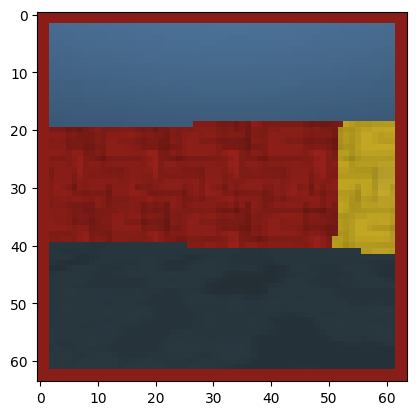

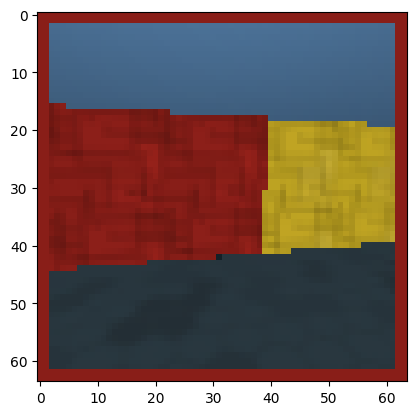

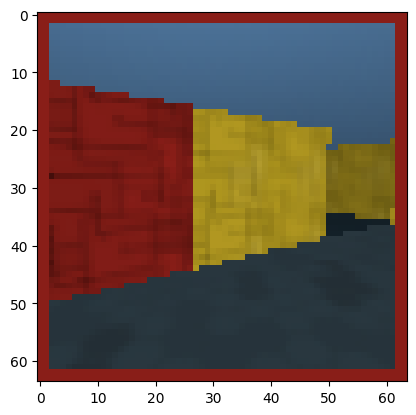

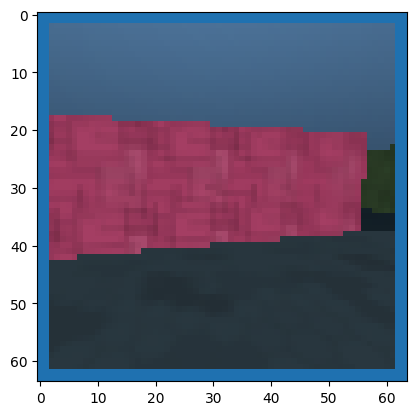

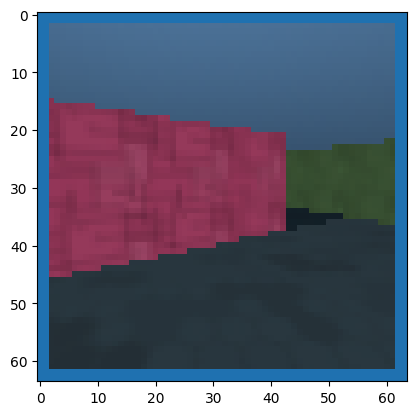

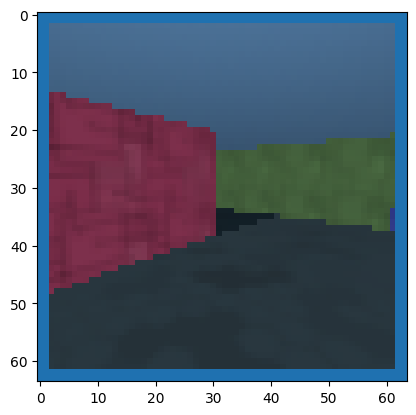

In [85]:
for img in states:
    plt.imshow(img)
    plt.show()

for img in states2:
    plt.imshow(img)
    plt.show()

In [90]:
logits = torch.tensor([-0.4078,  0.0814,  0.7492, -0.4956,  0.9032, -0.7841])
print(logits)
probs = torch.softmax(logits, dim=-1)
print(probs)
act = np.random.choice(np.arange(env.action_space.n), p=torch.softmax(probs, dim=-1).squeeze().detach().cpu().numpy())
print(act)

tensor([-0.4078,  0.0814,  0.7492, -0.4956,  0.9032, -0.7841])
tensor([0.0899, 0.1466, 0.2859, 0.0823, 0.3335, 0.0617])
5


In [80]:
env.action_space.n

6

In [76]:
print(dir(env.action_space))

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_np_random', '_shape', 'contains', 'dtype', 'from_jsonable', 'is_np_flattenable', 'n', 'np_random', 'sample', 'seed', 'shape', 'start', 'to_jsonable']


In [27]:
print(dir(env))

['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_action_space', '_disable_render_order_enforcing', '_has_reset', '_metadata', '_np_random', '_observation_space', '_reward_range', 'action_space', 'class_name', 'close', 'env', 'has_reset', 'metadata', 'new_step_api', 'np_random', 'observation_space', 'render', 'render_mode', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']


/home/user/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/home/user/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/home/user/conda/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisat

ValueError: too many values to unpack (expected 4)

In [24]:
info

{}

In [ ]:
.